## Importazione librerie

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import glob
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import sounddevice as sd

import scipy
from scipy.io import wavfile as wav

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils, to_categorical

from sklearn import preprocessing

Using TensorFlow backend.


## Definizione dei parametri

In [2]:
parent_dir = os.getcwd() + '\\recordings'
fold_names = os.listdir(parent_dir)
sound_names = os.listdir(parent_dir)

In [3]:
frames = 41
bands = 60
feature_size = bands * frames #60x41
num_labels = 3
num_channels = 2

In [4]:
model_path = os.getcwd() + '\\audio_model_CNN_bicanale.h5'
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto', restore_best_weights = True)
modelcheckpoint = ModelCheckpoint(model_path, save_best_only = True)

## Definizione delle funzioni da utilizzare

In [5]:
#CREAZIONE X_FEATURE E Y PER IL MODELLO

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

        
    
def parse_audio_files(parent_dir, file_ext='*.wav', bands=60, frames = 41):
    
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []    
    
    for cartella in os.listdir(parent_dir): 
        for fn in os.listdir(parent_dir + '\\' + cartella):
            label = str(cartella)
            file_name = parent_dir + '\\' + cartella + '\\' + fn
            sound, sr = librosa.load(file_name)
            for (start,end) in windows(sound,window_size):
                if(len(sound[start:end]) == int(window_size)):
                    signal = sound[start:end]
                    labels = np.append(labels, label)
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.amplitude_to_db(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
    log_specgrams = np.asarray(log_specgrams).reshape(-1,bands,frames,1)
                    
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels)



In [6]:
def categorizer(y): 
    label = preprocessing.LabelEncoder()
    categorical = label.fit_transform(y)
    return categorical

In [7]:
def build_model():
    
    model = Sequential()
    
    f_size = 1

    model.add(Convolution2D(512, f_size, strides=f_size, kernel_initializer='normal', padding='same', input_shape=(bands, frames, num_channels)))
    model.add(Convolution2D(256, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))
    
    model.add(Convolution2D(128, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Convolution2D(64, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))

    model.add(Flatten())

    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_labels))
    model.add(Activation('softmax'))

    adam = Adam(lr=0.0001)#, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
    
    return model

## Modello

In [8]:
X_feature, y = parse_audio_files(parent_dir)

In [9]:
np.unique(y)

array(['Federica', 'Giulia', 'Sconosciuto'], dtype='<U32')

In [10]:
print("{n_signals} signals with {n_features} features each one.".format(n_signals = len(X_feature), n_features = len(X_feature[0])))

2205 signals with 60 features each one.


In [11]:
y_train_cat = categorizer(y)
np.unique(y_train_cat, return_counts = True)

(array([0, 1, 2], dtype=int64), array([ 538,  505, 1162], dtype=int64))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_train_cat, test_size=0.1, random_state=1)

In [13]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [14]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 41, 512)       1536      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 41, 256)       131328    
_________________________________________________________________
activation_1 (Activation)    (None, 60, 41, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 20, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 20, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 20, 128)       32896     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 20, 64)       

In [15]:
history = model.fit(X_train, y_train_categorical,
                    validation_data=(X_test, y_test_categorical),
                    batch_size=32,
                    epochs=30,
                    callbacks = [earlystop, modelcheckpoint])

Train on 1984 samples, validate on 221 samples
Epoch 1/30
1984/1984 [==============================] - 58s 29ms/step - loss: 0.7535 - accuracy: 0.6537 - val_loss: 0.4049 - val_accuracy: 0.8552
Epoch 2/30
1984/1984 [==============================] - 57s 29ms/step - loss: 0.3385 - accuracy: 0.8589 - val_loss: 0.2156 - val_accuracy: 0.9276
Epoch 3/30
1984/1984 [==============================] - 56s 28ms/step - loss: 0.1980 - accuracy: 0.9299 - val_loss: 0.1613 - val_accuracy: 0.9593
Epoch 4/30
1984/1984 [==============================] - 58s 29ms/step - loss: 0.1551 - accuracy: 0.9410 - val_loss: 0.1315 - val_accuracy: 0.9683
Epoch 5/30
1984/1984 [==============================] - 57s 29ms/step - loss: 0.1203 - accuracy: 0.9592 - val_loss: 0.1117 - val_accuracy: 0.9729
Epoch 6/30
1984/1984 [==============================] - 59s 30ms/step - loss: 0.0982 - accuracy: 0.9662 - val_loss: 0.0984 - val_accuracy: 0.9774
Epoch 7/30
1984/1984 [==============================] - 57s 29ms/step - loss:

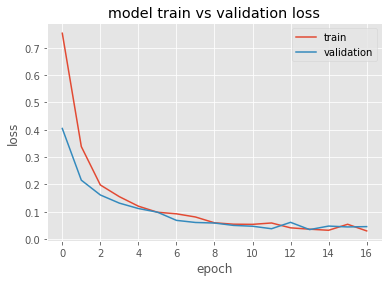

In [16]:
# loss function

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

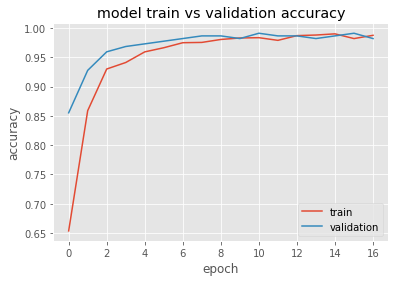

In [17]:
# accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.show()